# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Подгружаем необходимые бибилиотеки и фиксируем псевдослучайную последовательность.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import re
import nltk
from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
from nltk.probability import FreqDist

import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
import spacy

import time 

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

state = 12345

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 44.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Изучаем данные. Проверяем их на повторы, количество уникальных значений, распределение целевого значения.

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.sample(10))
display(data.info())
display(data.duplicated().sum())   
display(data['toxic'].describe())
display(data.isna().sum())
display(data['toxic'].nunique())  
display(data['toxic'].value_counts())  

,Unnamed: 0,text,toxic
105139,105236,Hello \n\nGo back to your own country you brit...,1
92004,92095,"""\n\nReply Remove Incorrect Libelous Comment B...",0
57898,57962,"Agreed. Alan cites Cecil Papers, iv. pp. 394-...",0
16670,16687,"""\n\nNot enough in-line citations\nPerhaps you...",0
16029,16046,"Fine, I won't do it again. Still, that doesn't...",0
57293,57354,"""\n\nEven so, that does not imply that: Mexico...",0
16937,16954,"""\nWell, I see what you are talking about, but...",0
55007,55068,HELLO RODENT\nHello there partisan liberal age...,1
66863,66930,I have removed speedy delete tag per above,0
42523,42573,Inaccurate pressure/wind graphic \nThe arrows ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

0

count    159292.000000
mean          0.101612
std           0.302139
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64

Unnamed: 0    0
text          0
toxic         0
dtype: int64

2

0    143106
1     16186
Name: toxic, dtype: int64

Видно, что в данных нет пропусков. Но также очевидно, что выборка разбалансирована. Далее необходимо будет учесть этот момент для более качественного обучения моделей.

Проведем лемматизацию и очистку всех текстов с помощью spacy.

In [3]:
%%time
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text_l):
    text_l = text_l.lower()
    doc = nlp(text_l)
    lemm_text = " ".join([token.lemma_ for token in doc])
    cleared_lemm = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return (" ".join(cleared_lemm.split()))


data['lemm_text'] = data['text'].apply(lemmatize)
data = data.drop(['text'], axis=1)

CPU times: user 20min 28s, sys: 5.54 s, total: 20min 34s
Wall time: 20min 35s


Лемматизация заняла 20 минут, 35 секунд. Далее проверим ее успешность, а также выведем список наиболее употребляемых слов и вихуализируем эти данные.

In [4]:
display(data.sample(10))

#print(pd.Series(' '.join(data.lemm_text).split()).value_counts()[:10])


a = data['lemm_text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)


rslt = pd.DataFrame(word_dist.most_common(40),
                    columns=['Word', 'Frequency'])
print(rslt)

,Unnamed: 0,toxic,lemm_text
110503,110600,0,you currently appear to be engage in an edit w...
39588,39638,0,the precise definition of race be under disput...
119990,120095,0,I be not go to rise to the bait that I have to...
2300,2300,0,interesting only way to keep the pov go be to ...
62816,62883,0,it be shaka s single minded ambition and deter...
14640,14656,0,a tag have be place on diminish light band req...
24556,24579,0,do now what his ministry be and what type of s...
39577,39627,1,my personal opinion be that you be a fucking w...
58895,58961,0,thank you for point it out talk contrib
53448,53509,0,to an article I have create


<FreqDist with 153774 samples and 10856069 outcomes>
         Word  Frequency
0          be     526263
1         the     496114
2          to     297635
3           i     279091
4          of     224547
5         and     223638
6         you     219623
7           a     216969
8        that     161280
9         not     159496
10         it     148306
11         in     145514
12       have     121927
13         do     115866
14        for     102730
15       this      97408
16         on      89787
17         as      77272
18    article      74143
19       your      63695
20       with      59446
21         if      58525
22       page      57035
23         or      53289
24        but      50963
25  wikipedia      48566
26         my      45542
27         an      44941
28       they      43888
29        can      43375
30       from      41420
31         by      41072
32          s      40545
33       talk      40386
34         at      39473
35         he      37205
36      about      370

<AxesSubplot:title={'center':'График встречаемости слов'}, xlabel='Word', ylabel='Frequency'>

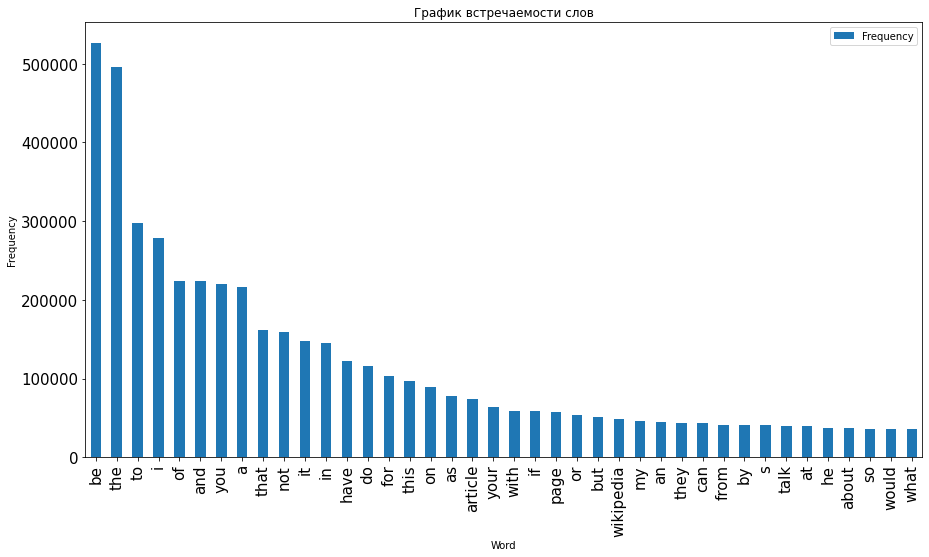

In [5]:
rslt[['Word', 'Frequency']].plot(figsize=(15,8),
                                 title='График встречаемости слов',
                                 ylabel='Frequency',
                                 xlabel='Word',
                                 x="Word",
                                 y="Frequency",
                                 kind="bar",
                                 fontsize=15)

## Обучение

Выделим целевой признак и разделим выборку на тренировочную и тестовую в процпорции 4:1

In [6]:
target = data['toxic']
features = data.drop(['toxic'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=state, stratify=target)

Подсчитаем насколько разбалансированы классы.

In [7]:
#count_tf_idf = TfidfVectorizer(stop_words=stopwords,  ngram_range=(1, 2)) 
#features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
#features_test = count_tf_idf.transform(features_test['lemm_text'])
#print(features_train.shape)
#print(features_test.shape)

In [8]:
display(target_train.value_counts()[0]/target_train.value_counts()[1])

8.841146034442815

Видно, что соотношение классов примерно равно 8.84. Далее обучим модель логистической регрессии на тренировочной выборке с помощью пайплайн и балансировки классов, посчитаем f1.

In [13]:
%%time
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=state))])

params = {'clf__C': [1, 10, 100],
          'clf__class_weight': ['balanced'],
          'clf__solver' : ['lbfgs', 'liblinear']}

lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=3, scoring='f1', n_jobs=-1)
lr_grid.fit(features_train['lemm_text'], target_train)
lr_best_paramms = lr_grid.best_params_

print(lr_best_paramms)
print(lr_grid.best_score_)
print(lr_grid.best_estimator_)

{'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__solver': 'lbfgs'}
0.7740039301446314
CPU times: user 8min 19s, sys: 7min 6s, total: 15min 25s
Wall time: 15min 26s


Результат на тренировочной выборке получился 0.7740, время обучения 15 минут, 26 секунд.

<div class="alert alert-success">


О pipeline:

[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), это тема которая сразу затрагивает кроссвалидацию, тюнинг "векторайз", подбор гиперпараметров модели и о том что код стоит делать компактным.
    
    
- в TfidfVectorizer(stop_words=stopwords) у тебя по умолчанию ngram_range=(1, 1), тут можно подбирать разное число n- грамм (и другие параметры), максимизируя метрику, но как объединить перебор по ngram_range с обучением моделей, чтобы не делать это по отдельности или с использованием цикла?! pipeline! Готовый [пример для работы с текстами](https://medium.com/@yoni.levine/how-to-grid-search-with-a-pipeline-93147835d916). Всё что нужно там есть, хотя очень лаконично. Можешь погуглить по:


    
    pipeline nlp gridsearchcv



- как избежать ошибки подглядывания в будущее, когда мы предварительно работаем с данными (шкалирование, нормализация, TfidfVectorizer итп итд)? pipeline! особенно это важно, когда мы используем кроссвалидацию. Для TfidfVectorizer делаем .fit (обучаемся) на train, а transform на test, но точно также нужно сделать для валидационной выборки. Но GS делает валидационные внутри себя, спрашивается как добраться до нее и избежать подглядывания в будущее? Казалось бы никак, но нет! Pipeline! ) 
    
    
- pipeline позволяет делать наш код компактней и читабельней, это большой плюс, когда код будет раздуваться     
    
    

         
Если раньше не использовалА pipeline то могу посоветовать видео в котором [индус](https://www.youtube.com/watch?v=mOYJCR0IDk8&ab_channel=HimanshuChandra) на английском с сильным акцентом, но на пальцах обьясняет  самое непонятное (по моему опыту): сопряженность методов fit и transform. Там же есть и код и ссылка на текст. Мне помогло )
    
<div>   

Далее обучим модель LGBM на тренировочной выборке с помощью пайплайн и балансировки классов, посчитаем f1.

In [29]:
%%time
LGBM_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, stop_words=stopwords)),
    ('clf', LGBMClassifier(random_state=state))])

params = {'clf__num_leaves':[30, 100],
        'clf__random_state' : [state],
        'clf__learning_rate' :[0.1]} 

LGBM_grid = GridSearchCV(estimator=LGBM_pipe, param_grid=params, cv=3, scoring='f1', n_jobs=-1)
LGBM_grid.fit(features_train['lemm_text'], target_train)
LGBM_best_paramms = LGBM_grid.best_params_

print(LGBM_best_paramms)
print(LGBM_grid.best_score_)
print(LGBM_grid.best_estimator_)

{'clf__learning_rate': 0.1, 'clf__num_leaves': 100, 'clf__random_state': 12345}
0.7735301437876312
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('clf', LGBMClassifier(num_leaves=100, random_state=12345))])
CPU times: user 29min 19s, sys: 6.48 s, total: 29min 25s
Wall time: 29min 33s


Результат метрики 0.7735, время обучения 29 минут, 33 секунды. Результаты у обеих моделей очень близки, хотя модель логистической регрессии обучается примерно в 2 раза быстрее. Есть смысл проверить модели на тестовой выборке, учитывая близость показателей.

In [35]:
model_lr=lr_grid.best_estimator_
predict = model_lr.predict(features_test['lemm_text'])
test_f1_lr = f1_score(target_test, predict)
print('Показатель модели логистической регрессии на тестовых данных', test_f1_lr)

model_LGBM=LGBM_grid.best_estimator_
predict = model_LGBM.predict(features_test['lemm_text'])
test_f1_LGBM = f1_score(target_test, predict)
print('Показатель модели LGBM на тестовых данных', test_f1_LGBM)

Показатель модели логистической регрессии на тестовых данных 0.7844202898550724
Показатель модели LGBM на тестовых данных 0.7796726959517657


Видно, что показатели на тестовых выборках также очень близки, но все же у логистической регрессии немного лучше: 0.784 против 0.779. Учитывая, что она обучается быстрее, она является лучшей моделью. Также оба показателя удовлетворяют условию (>0,75)

## Выводы

1. Были изучены и проанализированы входные данные. Мы рассмотрели распределение данных, проанализировали их. Обнаружили разбалансированность классов и устраниили ее.
2. Мы обучили 2 разные модели с пайплайном, перебором гиперпараметров и кросс-валидацией, вычислили для каждой из них метрику качества f1 и время обучения и предсказания.
3. С учетом условия задачи, лучшей моделью быа выбрана LogisticRegression.
4. Для нее был выполнен расчет метрики f1 на тестовой выборке, метрика показала 0.784, что больше 0.75, а значит соответствует условию.


<div class="alert alert-info">

<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .
</font>


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны